In [104]:
import numpy as np
import matplotlib.pyplot as plt
from pyTMD.time import convert_calendar_dates, datetime_to_list
from pyTMD.io import model, GOT
from pyTMD.predict import time_series, infer_minor


In [105]:
lon = 122.26672
lat = 23.76175

# Model parameters
model_directory = '/media/X/temp/tide/GOT4.10/'
model_format = 'netcdf'
compressed = False


In [111]:
# Create model object
tide_model = model(model_directory, format=model_format, compressed=compressed).elevation('GOT4.10')

# Load and interpolate tidal constants
constituents = GOT.read_constants(
    tide_model.model_file, compressed=tide_model.compressed)
amp, ph = GOT.interpolate_constants(np.array([lon]), np.array([lat]),  
                                    constituents, scale=tide_model.scale, 
                                    method='spline', extrapolate=True)

print(amp)
print(ph)
print(len(constituents))
print(amp.shape)
print(ph.shape)

[[0.030943674966692924 0.15202389657497406 0.056997451931238174
  0.1767793744802475 0.08910463750362396 0.4602945148944855
  0.18891607224941254 0.05152113735675812 0.0069605265744030476
  0.0009311279281973839]]
[[65.07211380768192 77.45015828198338 96.73382453549121 98.68804410986941
  289.2768677108055 297.7108604300181 322.32758961389067
  322.73642083194557 285.5496812920537 239.01022028769088]]
10
(1, 10)
(1, 10)


In [112]:
from datetime import datetime, timedelta

# Only one day timing (24 hours, 1-hour intervals)
# hours = np.arange(0, 24, 1)
# tide_time = convert_calendar_dates(2023, 7, 24, hour=hours)

# Create a list to hold all the hours arrays
# all_hours = []
# all_tide_times = []

# Generate arrays for each day
# for day in range(25, 29):  # 25, 26, 27, 28
#    hours = np.arange(0, 24, 1)
#    all_hours.append(hours)
#    
#    tide_time = convert_calendar_dates(2023, 7, day, hour=hours)
#    all_tide_times.append(tide_time)

# Concatenate all the arrays
# hours = np.concatenate(all_hours)
# tide_time = np.concatenate(all_tide_times)
# print(tide_time)

# Create start and end date
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)

# Generate a list of every hour between start and end date
dtime = []
tide_time = []
while start_date <= end_date:
    dtime.append(start_date)
    dtlist = datetime_to_list(start_date)
    tide_time.append(convert_calendar_dates(dtlist[0], dtlist[1], dtlist[2], dtlist[3]))
    start_date += timedelta(hours=1)

tide_time = np.array(tide_time)
print(tide_time)

[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11530.79

In [113]:
# calculate complex phase in radians for Euler's
cph = -1j * ph * np.pi / 180.0
# calculate constituent oscillation
hc = amp * np.exp(cph)
c = constituents.fields
DELTAT = np.zeros_like(tide_time)

# Predict tide
tide = time_series(tide_time, hc, c, deltat=DELTAT, corrections=tide_model.format)
minor = infer_minor(tide_time,hc, c, deltat=DELTAT, corrections=tide_model.format)
tide.data[:] += minor.data[:]
# convert to centimeters
tide.data[:] *= 100.0
print(tide.data.shape)

(73,)


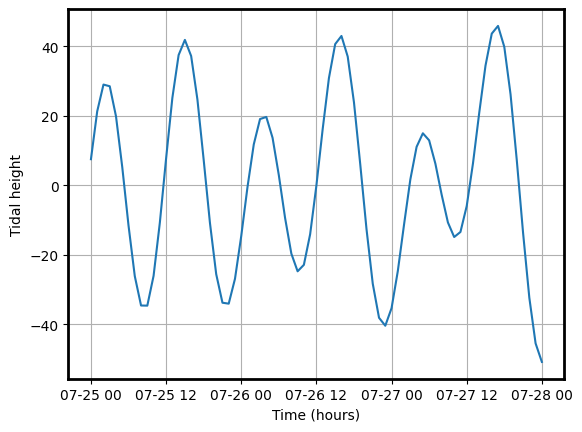

In [114]:
# Plot tidal height
plt.figure()
plt.plot(dtime, tide.data)
plt.xlabel('Time (hours)')
plt.ylabel('Tidal height')
plt.grid()
plt.show()


In [110]:
# available model list for current
model_list = sorted(model.global_current() + model.antarctic_current())
print(model_list)

['CATS0201', 'CATS2008', 'CATS2022', 'FES2014', 'HAMTIDE11', 'TPXO7.2', 'TPXO8-atlas', 'TPXO9-atlas', 'TPXO9-atlas-v2', 'TPXO9-atlas-v3', 'TPXO9-atlas-v4', 'TPXO9-atlas-v5', 'TPXO9.1']
